<a href="https://colab.research.google.com/github/karavdin/smartPiCar/blob/main/code/training_tensorflow_lite_LEGO_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a model to detect LEGO objects with Raspberry Pi in Real Time

This notebook is based on tutorial and Colab Notebook ["Training a Raspberry Pi to Detect Traffic Signs and People in Real Time"](https://github.com/dctian/DeepPiCar/blob/master/models/object_detection/code/tensorflow_traffic_sign_detection.ipynb). The original notebook was written 4 years ago and does not work. Therefore is was updated following methods used in 
["TensorFlow Lite Python object detection example with Raspberry Pi"](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/raspberry_pi) from Tensorflow-Lite team.  

As the Raspberry Pi is fairly limited on CPU power and can only run object detection at 1-2 FPS (frames/sec), Google's [EdgeTPU USB Accelarator](https://coral.withgoogle.com/products/accelerator), which can detect objects at 12 FPS, will be used for the model inference.

# Section 0: Check GPU connection

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Apr  7 18:44:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


# Section 1: Install and import packages

In [3]:
!pip install -q tflite-model-maker
!pip install -q tflite-support

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.3/577.3 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 KB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 KB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 19.5 MB/s eta 

In [4]:
import numpy as np
import os

from tflite_model_maker.config import ExportFormat, QuantizationConfig
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

from tflite_support import metadata

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're usin

RuntimeError: ignored

# Section 2: Prepare dataset

## Clone repository with data and labels

In [5]:
# If you forked the repository, you can replace the link.
repo_url = 'https://github.com/karavdin/smartPiCar'

In [6]:
import os
import pandas as pd

%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}

print('Pull it so that we have the latest code/data')
!git pull

/content
Cloning into 'smartPiCar'...
remote: Enumerating objects: 262, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 262 (delta 5), reused 18 (delta 3), pack-reused 239
Receiving objects: 100% (262/262), 104.88 MiB | 18.64 MiB/s, done.
Resolving deltas: 100% (116/116), done.
/content/smartPiCar
Pull it so that we have the latest code/data
Already up to date.


In [7]:
#%cd {repo_dir_path}/models/object_detection

# Convert train folder annotation xml files to a single csv file,
# generate the `label_map.pbtxt` file to `data/` directory as well.
!python code/xml_to_csv.py -i data/images/train -o data/annotations/train_labels.csv -l data/annotations

Successfully converted xml to csv.
Generate `data/annotations/label_map.pbtxt`


In [10]:
df_train_labels = pd.read_csv('data/annotations/train_labels.csv')
labels = list(df_train_labels['class'].unique())
print(labels)


['bike', 'clock', 'Babushka', 'e-bike station', 'Sheila', 'Capitan', 'Bob', 'Phil', 'Nastya', 'Cam', 'ukulele', 'disko', 'Ukulele']


In [11]:
train_data = object_detector.DataLoader.from_pascal_voc(
    'data/images/train',
    'data/images/train',
    labels
)

val_data = object_detector.DataLoader.from_pascal_voc(
    'data/images/test',
    'data/images/test',
    labels
)

# Section 3: Select a model architecture

EfficientDet-Lite[0-4] are a family of mobile/IoT-friendly object detection models derived from the [EfficientDet](https://arxiv.org/abs/1911.09070) architecture.

Here is the performance of each EfficientDet-Lite models compared to each others.

| Model architecture | Size(MB)* | Latency(ms)** | Average Precision*** |
|--------------------|-----------|---------------|----------------------|
| EfficientDet-Lite0 | 4.4       | 146           | 25.69%               |
| EfficientDet-Lite1 | 5.8       | 259           | 30.55%               |
| EfficientDet-Lite2 | 7.2       | 396           | 33.97%               |
| EfficientDet-Lite3 | 11.4      | 716           | 37.70%               |
| EfficientDet-Lite4 | 19.9      | 1886          | 41.96%               |

<i> * Size of the integer quantized models. <br/>
** Latency measured on Raspberry Pi 4 using 4 threads on CPU. <br/>
*** Average Precision is the mAP (mean Average Precision) on the COCO 2017 validation dataset.
</i>

In this notebook, we use EfficientDet-Lite0 to train our model. You can choose other model architectures depending on whether speed or accuracy is more important to you.

In [13]:
spec = model_spec.get('efficientdet_lite0')

# Section 4: Train the TensorFlow model with the training data.

* Set `epochs = 20`, which means it will go through the training dataset 20 times. You can look at the validation accuracy during training and stop when you see validation loss (`val_loss`) stop decreasing to avoid overfitting.
* Set `batch_size = 4` here so you will see that it takes 15 steps to go through the 62 images in the training dataset.
* Set `train_whole_model=True` to fine-tune the whole model instead of just training the head layer to improve accuracy. The trade-off is that it may take longer to train the model.

## Mount Google Drive
Mount my Google Drive and save modeling output files (`.ckpt`)  there, so that it won't be wiped out when colab Virtual Machine restarts.  It has an idle timeout of 90 min, and maximum daily usage of 12 hours.

Google will ask for an authenticate code when you run the following code, just follow the link in the output and allow access.   You can put the `model_dir` anywhere in your google drive.

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
model_dir = '/content/gdrive/My Drive/Colab Notebooks/SmartPiCar_Training'
# !rm -rf '{model_dir}'
# os.makedirs(model_dir, exist_ok=True)

#!ls -ltra '{model_dir}'/..
!ls -ltra '{model_dir}'

In [ ]:
spec #START HERE

* Set `epochs = 20`, which means it will go through the training dataset 20 times. You can look at the validation accuracy during training and stop when you see validation loss (`val_loss`) stop decreasing to avoid overfitting.
* Set `batch_size = 4` here so you will see that it takes 15 steps to go through the 62 images in the training dataset.
* Set `train_whole_model=True` to fine-tune the whole model instead of just training the head layer to improve accuracy. The trade-off is that it may take longer to train the model.

In [14]:
model = object_detector.create(train_data, model_spec=spec, batch_size=4, train_whole_model=True, epochs=20, validation_data=val_data)

Epoch 1/20
24/24 [==============================] - 81s 1s/step - det_loss: 1.9090 - cls_loss: 1.2176 - box_loss: 0.0138 - reg_l2_loss: 0.0650 - loss: 1.9740 - learning_rate: 0.0065 - gradient_norm: 1.7458 - val_det_loss: 1.5812 - val_cls_loss: 1.1518 - val_box_loss: 0.0086 - val_reg_l2_loss: 0.0650 - val_loss: 1.6461
Epoch 2/20
24/24 [==============================] - 28s 1s/step - det_loss: 1.6669 - cls_loss: 1.1606 - box_loss: 0.0101 - reg_l2_loss: 0.0650 - loss: 1.7319 - learning_rate: 0.0049 - gradient_norm: 1.6362 - val_det_loss: 1.4936 - val_cls_loss: 1.1178 - val_box_loss: 0.0075 - val_reg_l2_loss: 0.0650 - val_loss: 1.5585
Epoch 3/20
24/24 [==============================] - 31s 1s/step - det_loss: 1.6169 - cls_loss: 1.1178 - box_loss: 0.0100 - reg_l2_loss: 0.0650 - loss: 1.6818 - learning_rate: 0.0048 - gradient_norm: 2.1117 - val_det_loss: 1.4038 - val_cls_loss: 1.0650 - val_box_loss: 0.0068 - val_reg_l2_loss: 0.0650 - val_loss: 1.4688
Epoch 4/20
24/24 [======================

# Section 5: Evaluate the model with the validation data.

After training the object detection model using the images in the training dataset, use the 10 images in the validation dataset to evaluate how the model performs against new data it has never seen before.

As the default batch size is 64, it will take 1 step to go through the 10 images in the validation dataset.

The evaluation metrics are same as [COCO](https://cocodataset.org/#detection-eval).

In [16]:
model.evaluate(val_data)

1/1 [==============================] - 15s 15s/step



{'AP': 0.16553015,
 'AP50': 0.27937025,
 'AP75': 0.17985469,
 'APs': -1.0,
 'APm': 0.0,
 'APl': 0.17460582,
 'ARmax1': 0.19907469,
 'ARmax10': 0.38149515,
 'ARmax100': 0.38149515,
 'ARs': -1.0,
 'ARm': 0.0,
 'ARl': 0.4137823,
 'AP_/bike': 0.24742538,
 'AP_/clock': 0.38730344,
 'AP_/Babushka': 0.30885422,
 'AP_/e-bike station': 0.026753686,
 'AP_/Sheila': 0.0671989,
 'AP_/Capitan': 0.20726614,
 'AP_/Bob': 0.14911343,
 'AP_/Phil': 0.2423714,
 'AP_/Nastya': 0.010738766,
 'AP_/Cam': 0.17380619,
 'AP_/ukulele': 0.0,
 'AP_/disko': -1.0,
 'AP_/Ukulele': -1.0}

# Section 6: Export as a TensorFlow Lite model.

Export the trained object detection model to the TensorFlow Lite format by specifying which folder you want to export the quantized model to. The default post-training quantization technique is [full integer quantization](https://www.tensorflow.org/lite/performance/post_training_integer_quant). This allows the TensorFlow Lite model to be smaller, run faster on Raspberry Pi CPU and also compatible with the Google Coral EdgeTPU.

In [17]:
model.export(export_dir='.', tflite_filename='android.tflite')

# Section 7:  Evaluate the TensorFlow Lite model.

Several factors can affect the model accuracy when exporting to TFLite:
* [Quantization](https://www.tensorflow.org/lite/performance/model_optimization) helps shrinking the model size by 4 times at the expense of some accuracy drop.
* The original TensorFlow model uses per-class [non-max supression (NMS)](https://www.coursera.org/lecture/convolutional-neural-networks/non-max-suppression-dvrjH) for post-processing, while the TFLite model uses global NMS that's much faster but less accurate.
Keras outputs maximum 100 detections while tflite outputs maximum 25 detections.

Therefore you'll have to evaluate the exported TFLite model and compare its accuracy with the original TensorFlow model.

In [18]:
model.evaluate_tflite('android.tflite', val_data)

20/20 [==============================] - 64s 3s/step



{'AP': 0.08020481,
 'AP50': 0.13134418,
 'AP75': 0.089029364,
 'APs': -1.0,
 'APm': 0.0,
 'APl': 0.085256234,
 'ARmax1': 0.09724919,
 'ARmax10': 0.13455689,
 'ARmax100': 0.13455689,
 'ARs': -1.0,
 'ARm': 0.0,
 'ARl': 0.15518458,
 'AP_/bike': 0.0939604,
 'AP_/clock': 0.36633664,
 'AP_/Babushka': 0.26448262,
 'AP_/e-bike station': 0.03170085,
 'AP_/Sheila': 0.021782178,
 'AP_/Capitan': 0.07967385,
 'AP_/Bob': 0.0,
 'AP_/Phil': 0.0016501651,
 'AP_/Nastya': 0.022666195,
 'AP_/Cam': 0.0,
 'AP_/ukulele': 0.0,
 'AP_/disko': -1.0,
 'AP_/Ukulele': -1.0}

# Section 9: Visual validation

In [19]:
#@title Load the trained TFLite model and define some visualization functions

#@markdown This code comes from the TFLite Object Detection [Raspberry Pi sample](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/raspberry_pi).

import platform
from typing import List, NamedTuple
import json

import cv2

Interpreter = tf.lite.Interpreter
load_delegate = tf.lite.experimental.load_delegate

# pylint: enable=g-import-not-at-top


class ObjectDetectorOptions(NamedTuple):
  """A config to initialize an object detector."""

  enable_edgetpu: bool = False
  """Enable the model to run on EdgeTPU."""

  label_allow_list: List[str] = None
  """The optional allow list of labels."""

  label_deny_list: List[str] = None
  """The optional deny list of labels."""

  max_results: int = -1
  """The maximum number of top-scored detection results to return."""

  num_threads: int = 1
  """The number of CPU threads to be used."""

  score_threshold: float = 0.0
  """The score threshold of detection results to return."""


class Rect(NamedTuple):
  """A rectangle in 2D space."""
  left: float
  top: float
  right: float
  bottom: float


class Category(NamedTuple):
  """A result of a classification task."""
  label: str
  score: float
  index: int


class Detection(NamedTuple):
  """A detected object as the result of an ObjectDetector."""
  bounding_box: Rect
  categories: List[Category]


def edgetpu_lib_name():
  """Returns the library name of EdgeTPU in the current platform."""
  return {
      'Darwin': 'libedgetpu.1.dylib',
      'Linux': 'libedgetpu.so.1',
      'Windows': 'edgetpu.dll',
  }.get(platform.system(), None)


class ObjectDetector:
  """A wrapper class for a TFLite object detection model."""

  _OUTPUT_LOCATION_NAME = 'location'
  _OUTPUT_CATEGORY_NAME = 'category'
  _OUTPUT_SCORE_NAME = 'score'
  _OUTPUT_NUMBER_NAME = 'number of detections'

  def __init__(
      self,
      model_path: str,
      options: ObjectDetectorOptions = ObjectDetectorOptions()
  ) -> None:
    """Initialize a TFLite object detection model.
    Args:
        model_path: Path to the TFLite model.
        options: The config to initialize an object detector. (Optional)
    Raises:
        ValueError: If the TFLite model is invalid.
        OSError: If the current OS isn't supported by EdgeTPU.
    """

    # Load metadata from model.
    displayer = metadata.MetadataDisplayer.with_model_file(model_path)

    # Save model metadata for preprocessing later.
    model_metadata = json.loads(displayer.get_metadata_json())
    process_units = model_metadata['subgraph_metadata'][0]['input_tensor_metadata'][0]['process_units']
    mean = 0.0
    std = 1.0
    for option in process_units:
      if option['options_type'] == 'NormalizationOptions':
        mean = option['options']['mean'][0]
        std = option['options']['std'][0]
    self._mean = mean
    self._std = std

    # Load label list from metadata.
    file_name = displayer.get_packed_associated_file_list()[0]
    label_map_file = displayer.get_associated_file_buffer(file_name).decode()
    label_list = list(filter(lambda x: len(x) > 0, label_map_file.splitlines()))
    self._label_list = label_list

    # Initialize TFLite model.
    if options.enable_edgetpu:
      if edgetpu_lib_name() is None:
        raise OSError("The current OS isn't supported by Coral EdgeTPU.")
      interpreter = Interpreter(
          model_path=model_path,
          experimental_delegates=[load_delegate(edgetpu_lib_name())],
          num_threads=options.num_threads)
    else:
      interpreter = Interpreter(
          model_path=model_path, num_threads=options.num_threads)

    interpreter.allocate_tensors()
    input_detail = interpreter.get_input_details()[0]

    # From TensorFlow 2.6, the order of the outputs become undefined.
    # Therefore we need to sort the tensor indices of TFLite outputs and to know
    # exactly the meaning of each output tensor. For example, if
    # output indices are [601, 599, 598, 600], tensor names and indices aligned
    # are:
    #   - location: 598
    #   - category: 599
    #   - score: 600
    #   - detection_count: 601
    # because of the op's ports of TFLITE_DETECTION_POST_PROCESS
    # (https://github.com/tensorflow/tensorflow/blob/a4fe268ea084e7d323133ed7b986e0ae259a2bc7/tensorflow/lite/kernels/detection_postprocess.cc#L47-L50).
    sorted_output_indices = sorted(
        [output['index'] for output in interpreter.get_output_details()])
    self._output_indices = {
        self._OUTPUT_LOCATION_NAME: sorted_output_indices[0],
        self._OUTPUT_CATEGORY_NAME: sorted_output_indices[1],
        self._OUTPUT_SCORE_NAME: sorted_output_indices[2],
        self._OUTPUT_NUMBER_NAME: sorted_output_indices[3],
    }

    self._input_size = input_detail['shape'][2], input_detail['shape'][1]
    self._is_quantized_input = input_detail['dtype'] == np.uint8
    self._interpreter = interpreter
    self._options = options

  def detect(self, input_image: np.ndarray) -> List[Detection]:
    """Run detection on an input image.
    Args:
        input_image: A [height, width, 3] RGB image. Note that height and width
          can be anything since the image will be immediately resized according
          to the needs of the model within this function.
    Returns:
        A Person instance.
    """
    image_height, image_width, _ = input_image.shape

    input_tensor = self._preprocess(input_image)

    self._set_input_tensor(input_tensor)
    self._interpreter.invoke()

    # Get all output details
    boxes = self._get_output_tensor(self._OUTPUT_LOCATION_NAME)
    classes = self._get_output_tensor(self._OUTPUT_CATEGORY_NAME)
    scores = self._get_output_tensor(self._OUTPUT_SCORE_NAME)
    count = int(self._get_output_tensor(self._OUTPUT_NUMBER_NAME))

    return self._postprocess(boxes, classes, scores, count, image_width,
                             image_height)

  def _preprocess(self, input_image: np.ndarray) -> np.ndarray:
    """Preprocess the input image as required by the TFLite model."""

    # Resize the input
    input_tensor = cv2.resize(input_image, self._input_size)

    # Normalize the input if it's a float model (aka. not quantized)
    if not self._is_quantized_input:
      input_tensor = (np.float32(input_tensor) - self._mean) / self._std

    # Add batch dimension
    input_tensor = np.expand_dims(input_tensor, axis=0)

    return input_tensor

  def _set_input_tensor(self, image):
    """Sets the input tensor."""
    tensor_index = self._interpreter.get_input_details()[0]['index']
    input_tensor = self._interpreter.tensor(tensor_index)()[0]
    input_tensor[:, :] = image

  def _get_output_tensor(self, name):
    """Returns the output tensor at the given index."""
    output_index = self._output_indices[name]
    tensor = np.squeeze(self._interpreter.get_tensor(output_index))
    return tensor

  def _postprocess(self, boxes: np.ndarray, classes: np.ndarray,
                   scores: np.ndarray, count: int, image_width: int,
                   image_height: int) -> List[Detection]:
    """Post-process the output of TFLite model into a list of Detection objects.
    Args:
        boxes: Bounding boxes of detected objects from the TFLite model.
        classes: Class index of the detected objects from the TFLite model.
        scores: Confidence scores of the detected objects from the TFLite model.
        count: Number of detected objects from the TFLite model.
        image_width: Width of the input image.
        image_height: Height of the input image.
    Returns:
        A list of Detection objects detected by the TFLite model.
    """
    results = []

    # Parse the model output into a list of Detection entities.
    for i in range(count):
      if scores[i] >= self._options.score_threshold:
        y_min, x_min, y_max, x_max = boxes[i]
        bounding_box = Rect(
            top=int(y_min * image_height),
            left=int(x_min * image_width),
            bottom=int(y_max * image_height),
            right=int(x_max * image_width))
        class_id = int(classes[i])
        category = Category(
            score=scores[i],
            label=self._label_list[class_id],  # 0 is reserved for background
            index=class_id)
        result = Detection(bounding_box=bounding_box, categories=[category])
        results.append(result)

    # Sort detection results by score ascending
    sorted_results = sorted(
        results,
        key=lambda detection: detection.categories[0].score,
        reverse=True)

    # Filter out detections in deny list
    filtered_results = sorted_results
    if self._options.label_deny_list is not None:
      filtered_results = list(
          filter(
              lambda detection: detection.categories[0].label not in self.
              _options.label_deny_list, filtered_results))

    # Keep only detections in allow list
    if self._options.label_allow_list is not None:
      filtered_results = list(
          filter(
              lambda detection: detection.categories[0].label in self._options.
              label_allow_list, filtered_results))

    # Only return maximum of max_results detection.
    if self._options.max_results > 0:
      result_count = min(len(filtered_results), self._options.max_results)
      filtered_results = filtered_results[:result_count]

    return filtered_results


_MARGIN = 10  # pixels
_ROW_SIZE = 10  # pixels
_FONT_SIZE = 1
_FONT_THICKNESS = 1
_TEXT_COLOR = (0, 0, 255)  # red


def visualize(
    image: np.ndarray,
    detections: List[Detection],
) -> np.ndarray:
  """Draws bounding boxes on the input image and return it.
  Args:
    image: The input RGB image.
    detections: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  for detection in detections:
    # Draw bounding_box
    start_point = detection.bounding_box.left, detection.bounding_box.top
    end_point = detection.bounding_box.right, detection.bounding_box.bottom
    cv2.rectangle(image, start_point, end_point, _TEXT_COLOR, 3)

    # Draw label and score
    category = detection.categories[0]
    class_name = category.label
    probability = round(category.score, 2)
    result_text = class_name + ' (' + str(probability) + ')'
    text_location = (_MARGIN + detection.bounding_box.left,
                     _MARGIN + _ROW_SIZE + detection.bounding_box.top)
    cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                _FONT_SIZE, _TEXT_COLOR, _FONT_THICKNESS)

  return image

In [23]:
PATH_TO_TEST_IMAGES_DIR

'/content/smartPiCar/data/images/test/'

In [24]:
!ls -l /content/smartPiCar/data/images/test/

total 16308
-rwxr-xr-x 1 root root 786213 Apr  7 18:46 test_102.jpg
-rw-r--r-- 1 root root   1704 Apr  7 18:46 test_102.xml
-rwxr-xr-x 1 root root 933040 Apr  7 18:46 test_10.jpg
-rw-r--r-- 1 root root   2620 Apr  7 18:46 test_10_labels.xml
-rwxr-xr-x 1 root root 776249 Apr  7 18:46 test_114.jpg
-rw-r--r-- 1 root root    782 Apr  7 18:46 test_114.xml
-rwxr-xr-x 1 root root 952087 Apr  7 18:46 test_17.jpg
-rw-r--r-- 1 root root   2151 Apr  7 18:46 test_17_lables.xml
-rwxr-xr-x 1 root root 936902 Apr  7 18:46 test_22.jpg
-rw-r--r-- 1 root root   2150 Apr  7 18:46 test_22_labels.xml
-rwxr-xr-x 1 root root 945599 Apr  7 18:46 test_23.jpg
-rw-r--r-- 1 root root   2390 Apr  7 18:46 test_23_labels.xml
-rwxr-xr-x 1 root root 942652 Apr  7 18:46 test_28.jpg
-rw-r--r-- 1 root root   2849 Apr  7 18:46 test_28_labels.xml
-rwxr-xr-x 1 root root 281513 Apr  7 18:46 test_2.jpg
-rw-r--r-- 1 root root   2617 Apr  7 18:46 test_2_labels.xml
-rwxr-xr-x 1 root root 946966 Apr  7 18:46 test_37.jpg
-rw-r--r-

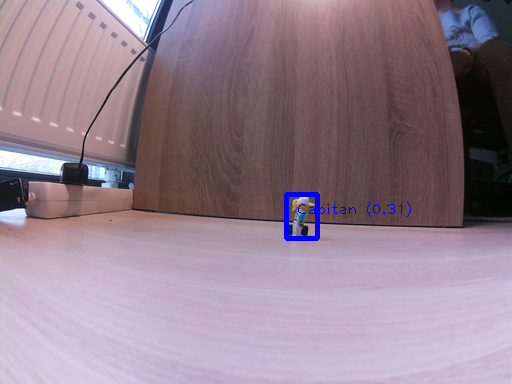

In [34]:
#@title Run object detection and show the detection results
from matplotlib import pyplot as plt
from PIL import Image

#INPUT_IMAGE_URL = "http://download.tensorflow.org/example_images/android_figurine.jpg" #@param {type:"string"}
DETECTION_THRESHOLD = 0.25 #@param {type:"number"}
TFLITE_MODEL_PATH = "android.tflite" #@param {type:"string"}

#TEMP_FILE = '/tmp/image.png'

#!wget -q -O $TEMP_FILE $INPUT_IMAGE_URL

PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "data/images/test/")

# directory = os.fsencode(PATH_TO_TEST_IMAGES_DIR)
# for input_file in os.listdir(directory):
#   filename = os.fsdecode(input_file)
#   #print(filename)
#   #if filename.endswith(".jpeg") or filename.endswith(".jpg"):
#   if filename == "test_6.jpg":
#     print('Running inference for {}... '.format(filename), end='')

image = Image.open(PATH_TO_TEST_IMAGES_DIR+"test_90.jpg").convert('RGB')
image.thumbnail((512, 512), Image.ANTIALIAS)
image_np = np.asarray(image)

# Load the TFLite model
options = ObjectDetectorOptions(
    num_threads=4,
    score_threshold=DETECTION_THRESHOLD,)
detector = ObjectDetector(model_path=TFLITE_MODEL_PATH, options=options)
# Run object detection estimation using the model.
detections = detector.detect(image_np)

# Draw keypoints and edges on input image
image_np = visualize(image_np, detections)

# Show the detection result
Image.fromarray(image_np)

# Section 10: Download the TFLite model to your local computer.

In [35]:
from google.colab import files
files.download('android.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
--- OLD CODE

SyntaxError: ignored

# Section 1: Mount Google drive
Mount my Google Drive and save modeling output files (`.ckpt`)  there, so that it won't be wiped out when colab Virtual Machine restarts.  It has an idle timeout of 90 min, and maximum daily usage of 12 hours.

Google will ask for an authenticate code when you run the following code, just follow the link in the output and allow access.   You can put the `model_dir` anywhere in your google drive.

In [ ]:

import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
model_dir = '/content/gdrive/My Drive/Colab Notebooks/DeepCar_Training'
# !rm -rf '{model_dir}'
# os.makedirs(model_dir, exist_ok=True)

#!ls -ltra '{model_dir}'/..
!ls -ltra '{model_dir}'

# Section 2: Configs and Hyperparameters

Support a variety of models, you can find more pretrained model from [Tensorflow detection model zoo: COCO-trained models](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models), as well as their pipline config files in [object_detection/samples/configs/](https://github.com/tensorflow/models/tree/master/research/object_detection/samples/configs).

# Not all models are suitable for transfer learning, see: 
https://github.com/tensorflow/models/issues/9287

In [ ]:
# If you forked the repository, you can replace the link.
repo_url = 'https://github.com/karavdin/DeepPiCar'

# Number of training steps.
#num_steps = 100000  # 200000
num_steps = 5000  # 200000

# Number of evaluation steps.
num_eval_steps = 50
#num_eval_steps = 5


# model configs are from Model Zoo github: 
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models
MODELS_CONFIG = {
    #http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_quantized_300x300_coco14_sync_2018_07_18.tar.gz
    'ssd_mobilenet_v1_quantized': {
        'model_name': 'ssd_mobilenet_v1_quantized_300x300_coco14_sync_2018_07_18',
        'pipeline_file': 'ssd_mobilenet_v1_quantized_300x300_coco14_sync.config',
        'batch_size': 12
    },    
    # 'ssd_mobilenet_v2': {
    #     'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
    #     'pipeline_file': 'ssd_mobilenet_v2_coco.config',
    #     'batch_size': 12
    # },
    #http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_quantized_300x300_coco_2019_01_03.tar.gz
    'ssd_mobilenet_v2_quantized': {
        'model_name': 'ssd_mobilenet_v2_quantized_300x300_coco_2019_01_03',
        'pipeline_file': 'ssd_mobilenet_v2_quantized_300x300_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 12
    },
    #TF2
    #http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
    'ssd_mobilenet_v2_tf2': { #VERY BAD results after 20k training
        'model_name': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8',
        #'pipeline_file': 'ssd_mobilenet_v3_small.config',
        'batch_size': 12
    },
    'ssd_resnet152_v1_tf2': { #Bad results, seems to be issue with saving model
        'model_name': 'ssd_resnet152_v1_fpn_1024x1024_coco17_tpu-8',
        'batch_size': 4
    },
    'ssd_mobilenet_v2_640_tf2': { 
        'model_name': 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8',
        #'pipeline_file': 'ssd_mobilenet_v3_small.config',
        'batch_size': 12
    },
    
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
# Note: for Edge TPU, you have to:
# 1) start with a pretrained model from model zoo, such as above 4
# 2) Must be a quantized model, which reduces the model size significantly
#selected_model = 'ssd_mobilenet_v2_quantized'
#selected_model = 'ssd_mobilenet_v2_tf2'
#selected_model = 'ssd_resnet152_v1_tf2'
selected_model = 'ssd_mobilenet_v2_640_tf2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
#pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

# Section 3: Set up Training Environment

## Clone the `DeepPiCar` repository or your fork.

In [ ]:
import os
import pandas as pd

%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}

print('Pull it so that we have the latest code/data')
!git pull

## Install required packages

In [ ]:

#!pip uninstall tensorflow

In [ ]:
%cd /content

# !pip install tf_slim
# !pip install tensorflow_io
# !pip install tensorflow-addons
!pip install tensorflow==2.11.0
#!pip install --ignore-installed --upgrade tensorflow==1.15

In [ ]:
import tensorflow as tf
print("--- Tensorflow version --- \n", tf.__version__)
#print(tf.reduce_sum(tf.random.normal([1000, 1000])))

In [ ]:
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk
!pip install -q cython contextlib2 pillow lxml matplotlib
#!pip install git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI


# !git clone https://github.com/cocodataset/cocoapi.git
# %cd cocoapi/PythonAPI
# !make
# !cp -r pycocotools /content/models/research/

!pip install -q pycocotools

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

!cp object_detection/packages/tf2/setup.py .
!python -m pip install --use-feature=2020-resolver .

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/:/content/models/'

import sys
sys.path.append("/content/models")

#!python object_detection/builders/model_builder_test.py

In [ ]:
!python object_detection/builders/model_builder_tf2_test.py

## Prepare `tfrecord` files

Use the following scripts to generate the `tfrecord` files.

```

In [ ]:
%cd {repo_dir_path}/models/object_detection

# Convert train folder annotation xml files to a single csv file,
# generate the `label_map.pbtxt` file to `data/` directory as well.
!python code/xml_to_csv.py -i data/images_hh/train -o data/annotations_hh/train_labels.csv -l data/annotations_hh

# Convert test folder annotation xml files to a single csv.
!python code/xml_to_csv.py -i data/images_hh/test -o data/annotations_hh/test_labels.csv



In [ ]:
!ls

In [ ]:
df_train_labels = pd.read_csv('data/annotations_hh/train_labels.csv')
print(df_train_labels['class'].unique())

In [ ]:
df_test_labels = pd.read_csv('data/annotations_hh/test_labels.csv')
print(df_test_labels['class'].unique())

In [ ]:
# Generate `train.record`
!python code/generate_tfrecord.py --csv_input=data/annotations_hh/train_labels.csv --output_path=data/annotations_hh/train.record --img_path=data/images_hh/train --label_map data/annotations_hh/label_map.pbtxt

# Generate `test.record`
!python code/generate_tfrecord.py --csv_input=data/annotations_hh/test_labels.csv --output_path=data/annotations_hh/test.record --img_path=data/images_hh/test --label_map data/annotations_hh/label_map.pbtxt

In [ ]:
test_record_fname = repo_dir_path + '/models/object_detection/data/annotations_hh/test.record'
train_record_fname = repo_dir_path + '/models/object_detection/data/annotations_hh/train.record'
label_map_pbtxt_fname = repo_dir_path + '/models/object_detection/data/annotations_hh/label_map.pbtxt'

In [ ]:
#!cat data/annotations_hh/test_labels.csv

## Download base model

In [ ]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
#DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/'
DEST_DIR = '/content/models/research/pretrained_model_2'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)
print(MODEL,"from",MODEL_FILE)

In [ ]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

In [ ]:
fine_tune_checkpoint = os.path.join(DEST_DIR+"/checkpoint", "ckpt-0")
fine_tune_checkpoint

# Section 4: Transfer Learning Training

## Configuring a Training Pipeline

In [ ]:
import os
pipeline_fname = os.path.join(DEST_DIR, 'pipeline.config')
assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [ ]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [ ]:
import re

# training pipeline file defines:
# - pretrain model path
# - the train/test sets
# - ID to Label mapping and number of classes
# - training batch size
# - epochs to trains
# - learning rate
# - etc

# note we just need to use a sample one, and make edits to it.

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    s = s = re.sub(
        '(fine_tune_checkpoint_type: ".*?)(classification)(.*?")', 'fine_tune_checkpoint_type: "{}"'.format("detection"), s, 1)

    # fine_tune_checkpoint: downloaded pre-trained model checkpoint path
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test, we created earlier with our training/test sets
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED)(.*?")', 'input_path: "{}"'.format(train_record_fname), s, 1)
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED)(.*?")', 'input_path: "{}"'.format(test_record_fname), s, 1)

    # label_map_path: ID to label file
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps (Number of epochs to train)
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
  
    f.write(s)

In [ ]:
#!cat {label_map_pbtxt_fname}

In [ ]:
# look for num_classes: 13, since we have 13 different objects 
!cat {pipeline_fname}

## Run Tensorboard(Optional)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir '{model_dir}'

In [ ]:
!ls /content/gdrive/My\ Drive/Colab\ Notebooks/DeepCar_Training/fine_tuned_model/checkpoint/checkpoint

In [ ]:
# #%load_ext tensorboard
# %reload_ext tensorboard
# import tensorflow as tf
# import datetime, os

# logs_base_dir = "./logs"
# os.makedirs(logs_base_dir, exist_ok=True)
# #%tensorboard --logdir {model_dir}
# %tensorboard --logdir=f'{model_dir}/fine_tuned_model'

In [ ]:
#%tensorboard --logdir logs

In [ ]:
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip -o ngrok-stable-linux-amd64.zip

In [ ]:
# LOG_DIR = model_dir
# get_ipython().system_raw(
#     'tensorboard --logdir "{}" --host 0.0.0.0 --port 6006 &'
#     .format(LOG_DIR)
# )

In [ ]:
#get_ipython().system_raw('./ngrok http 6006 &')

### Get Tensorboard link

In [ ]:
# ! curl -s http://localhost:4040/api/tunnels | python3 -c \
#     "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

## Train the model

Now all inputs are set up, just train the model.   This process may take a few hours.   Since we are saving the model training results (model.ckpt-* files) in our google drive (a persistent storage that will survice the restart of our colab VM instance), we can safely leave and return a few hours later. 

In [ ]:
!pip install lvis

In [ ]:
# --- TRAINING ---
#num_steps = 20
#SendEmail("Colab train started")
!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir='{model_dir}' \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}
#SendEmail("Colab train finished")

In [ ]:
!ls -ltra '{model_dir}'

# Section 5: Save and Convert Model Output

## Exporting a Trained Inference Graph
Once your training job is complete, you need to extract the newly trained inference graph, which will be later used to perform the object detection. This can be done as follows:

In [ ]:
import os
import re
import numpy as np

output_directory = '%s/fine_tuned_model' % model_dir
os.makedirs(output_directory, exist_ok=True)

In [ ]:
!echo exporting the model in other way
!python /content/models/research/object_detection/exporter_main_v2.py \
--pipeline_config_path={pipeline_fname} \
--trained_checkpoint_dir='{model_dir}' \
--output_directory='{output_directory}' \
--input_type=image_tensor

## Run inference test
Test with images in repository `object_detection/data/images/test` directory.

In [ ]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "models/object_detection/data/images_hh/test/")

In [ ]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      numpy array with shape (img_height, img_width, 3)
    """
    
    return np.array(Image.open(path))

In [ ]:
def inference_with_plot(path2images, box_th=0.7):
    """
    Function that performs inference and plots resulting b-boxes
    
    Args:
      path2images: an array with pathes to images
      box_th: (float) value that defines threshold for model prediction.
      
    Returns:
      None
    """

    directory = os.fsencode(path2images)
    for input_file in os.listdir(directory):
      filename = os.fsdecode(input_file)
      if filename.endswith(".jpeg") or filename.endswith(".jpg"):
      #if filename == "test_6.jpg":
        print('Running inference for {}... '.format(filename), end='')
        #run_detector(detector, path2images+"/"+filename)

    # for image_path in path2images:

    #     print('Running inference for {}... '.format(image_path), end='')

        image_np = load_image_into_numpy_array(PATH_TO_TEST_IMAGES_DIR+'/'+filename)
        #image_np = load_image_into_numpy_array(PATH_TO_TEST_IMAGES_DIR+'/'+filename)
        
        input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
        detections = detect_fn(input_tensor)

        # All outputs are batches tensors.
        # Convert to numpy arrays, and take index [0] to remove the batch dimension.
        # We're only interested in the first num_detections.
        num_detections = int(detections.pop('num_detections'))
        detections = {key: value[0, :num_detections].numpy()
                      for key, value in detections.items()}
        
        detections['num_detections'] = num_detections

        # detection_classes should be ints.
        detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
        #print("detections['detection_classes']",detections['detection_classes'])
        #print("detections['detection_scores']",detections['detection_scores'])
        label_id_offset = 1
        image_np_with_detections = image_np.copy()

        viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=7,
                min_score_thresh=box_th,
                agnostic_mode=False,
                line_thickness=4)
        # font = ImageFont.truetype('arial.ttf', 30)
        plt.figure(figsize=(15,10))
        plt.imshow(image_np_with_detections)
        plt.show()
        print('Done')

In [ ]:
def nms(rects, thd=0.5):
    """
    Filter rectangles
    rects is array of oblects ([x1,y1,x2,y2], confidence, class)
    thd - intersection threshold (intersection divides min square of rectange)
    """
    out = []

    remove = [False] * len(rects)

    for i in range(0, len(rects) - 1):
        if remove[i]:
            continue
        inter = [0.0] * len(rects)
        for j in range(i, len(rects)):
            if remove[j]:
                continue
            inter[j] = intersection(rects[i][0], rects[j][0]) / min(square(rects[i][0]), square(rects[j][0]))

        max_prob = 0.0
        max_idx = 0
        for k in range(i, len(rects)):
            if inter[k] >= thd:
                if rects[k][1] > max_prob:
                    max_prob = rects[k][1]
                    max_idx = k

        for k in range(i, len(rects)):
            if (inter[k] >= thd) & (k != max_idx):
                remove[k] = True

    for k in range(0, len(rects)):
        if not remove[k]:
            out.append(rects[k])

    boxes = [box[0] for box in out]
    scores = [score[1] for score in out]
    classes = [cls[2] for cls in out]
    return boxes, scores, classes


def intersection(rect1, rect2):
    """
    Calculates square of intersection of two rectangles
    rect: list with coords of top-right and left-boom corners [x1,y1,x2,y2]
    return: square of intersection
    """
    x_overlap = max(0, min(rect1[2], rect2[2]) - max(rect1[0], rect2[0]));
    y_overlap = max(0, min(rect1[3], rect2[3]) - max(rect1[1], rect2[1]));
    overlapArea = x_overlap * y_overlap;
    return overlapArea


def square(rect):
    """
    Calculates square of rectangle
    """
    return abs(rect[2] - rect[0]) * abs(rect[3] - rect[1])

In [ ]:
# do not change anything in this cell
# importing all scripts that will be needed to export your model and use it for inference
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline

configs = config_util.get_configs_from_pipeline_file(f'{output_directory}/pipeline.config') # importing config
model_config = configs['model'] # recreating model config
detection_model = model_builder.build(model_config=model_config, is_training=False) # importing model

In [ ]:
lst = os.listdir(model_dir)
# find the last model checkpoint file, i.e. model.ckpt-1000.meta
lst = [l for l in lst if 'ckpt-' in l and '.index' in l]
#print(lst)
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.index', '')
#last_model = lst[steps.argmax()]
last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)

In [ ]:
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(last_model_path).expect_partial()

In [ ]:
from PIL import Image

def detect_fn(image):
    """
    Detect objects in image.
    
    Args:
      image: (tf.tensor): 4D input image
      
    Returs:
      detections (dict): predictions that model made
    """

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    #print("detections:",detections)
    return detections

In [ ]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [ ]:
#categories

In [ ]:
#!cat object_detection/utils/visualization_utils.py

In [ ]:
# Different font-type and font-size for labels text
!wget https://freefontsdownload.net/download/160187/arial.zip
!unzip arial.zip -d .
!sed -i "s/font = ImageFont.truetype('arial.ttf', 24)/font = ImageFont.truetype('arial.ttf', 102)/" object_detection/utils/visualization_utils.py
#!sed -i "s/font = ImageFont.truetype('arial.ttf', 92)/font = ImageFont.truetype('arial.ttf', 122)/" object_detection/utils/visualization_utils.py

In [ ]:
#PATH_TO_TEST_IMAGES_DIR

In [ ]:
inference_with_plot(PATH_TO_TEST_IMAGES_DIR)

In [ ]:
!ls /content/DeepPiCar/models/object_detection/data/images_hh/test/

# Store model as tf-light object

In [ ]:
!echo creates the frozen inference graph in fine_tune_model
# there is an "Incomplete shape" message.  but we can safely ignore that. 
!python /content/models/research/object_detection/export_tflite_graph_lib_tf2.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory='{output_directory}' \
    --trained_checkpoint_prefix='{last_model_path}'

In [ ]:
!tflite_convert --output_file model_sdd.tflite --saved_model_dir '{last_model_path}'

In [ ]:
!ls -lh '{output_directory}/checkpoint/checkpoint'

In [ ]:
#!rm -r '{output_directory}/saved_model'

In [ ]:
# # TEST
# !echo exporting the model
# # there is an "Incomplete shape" message.  but we can safely ignore that. 
# !python /content/models/research/object_detection/export_tflite_graph_lib_tf2.py \
#     --pipeline_config_path={pipeline_fname} \
#     --output_directory='{output_directory}' \
#     --trained_checkpoint_dir='{model_dir}'

# !echo convert saved model to TF-Lite
# #https://www.tensorflow.org/lite/models/convert/convert_models#convert_a_savedmodel_recommended_
# # Convert the model
# converter = tf.lite.TFLiteConverter.from_saved_model(f'{output_directory}/saved_model/') # path to the SavedModel directory
# tflite_model = converter.convert()

# # Save the model.
# with open(f'{output_directory}/saved_model/model_ssd.tflite', 'wb') as f:
#   f.write(tflite_model)
# !cp {label_map_pbtxt_fname} '{output_directory}/saved_model/.'

In [ ]:
# WORKS BUT GIVES WIERD RESULT
!echo exporting the model
# there is an "Incomplete shape" message.  but we can safely ignore that. 
!python /content/models/research/object_detection/export_tflite_graph_tf2.py \
    --pipeline_config_path={pipeline_fname} \
    --output_directory='{output_directory}' \
    --trained_checkpoint_dir='{model_dir}'

# !echo convert saved model to TF-Lite
# #https://www.tensorflow.org/lite/models/convert/convert_models#convert_a_savedmodel_recommended_
# # Convert the model
# converter = tf.lite.TFLiteConverter.from_saved_model(f'{output_directory}/saved_model/') # path to the SavedModel directory
# tflite_model = converter.convert()

# # Save the model.
# with open(f'{output_directory}/saved_model/model.tflite', 'wb') as f:
#   f.write(tflite_model)
# !cp {label_map_pbtxt_fname} '{output_directory}/saved_model/.'

!tflite_convert --output_file '{output_directory}/saved_model/model_sdd.tflite' --saved_model_dir '{output_directory}/saved_model/'
!ls -lh '{output_directory}/saved_model/'

To convert model see https://colab.research.google.com/github/google-coral/tutorials/blob/master/compile_for_edgetpu.ipynb
